# GAN训练
## 引入

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from models import GAN
from utils import load_safari

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## 环境参数

In [2]:
# run params
SECTION = "gan"
RUN_ID = "0001"
DATA_NAME = "camel"
RUN_FOLDER = f"run/{SECTION}/"
RUN_FOLDER += "_".join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.makedirs(os.path.join(RUN_FOLDER, "viz"))
    os.makedirs(os.path.join(RUN_FOLDER, "images"))
    os.makedirs(os.path.join(RUN_FOLDER, "weights"))

MODE = "build" # "load"

## 加载数据

In [3]:
(x_train, y_train) = load_safari(DATA_NAME)
x_train.shape

(80000, 28, 28, 1)

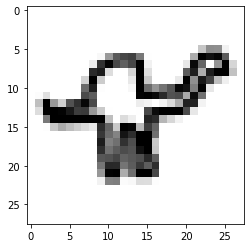

In [4]:
plt.imshow(x_train[200, :, :, 0], cmap="Greys")

## 神经网络结构

In [5]:
gan = GAN(
    input_dim=(28, 28, 1),
    discriminator_conv_filters=[64, 64, 128, 128],
    discriminator_conv_kernel_size=[5, 5, 5, 5],
    discriminator_conv_strides=[2, 2, 2, 1],
    discriminator_batch_norm_momentum=None,
    discriminator_activation="relu",
    discriminator_dropout_rate=0.4,
    discriminator_learning_rate=0.0008,
    generator_initial_dense_layer_size=(7, 7, 64),
    generator_upsample=[2, 2, 1, 1],
    generator_conv_filters=[128, 64, 64, 1],
    generator_conv_kernel_size=[5, 5, 5, 5],
    generator_conv_strides=[1, 1, 1, 1],
    generator_batch_norm_momentum=0.9,
    generator_activation="relu",
    generator_dropout_rate=None,
    generator_learning_rate=0.0004,
    optimizer="rmsprop",
    z_dim=100
)

if MODE == "build":
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, "weights/weights.h5"))

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
gan.discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (InputL  [(None, 28, 28, 1)]      0         
 ayer)                                                           
                                                                 
 discriminator_conv_0 (Conv2  (None, 14, 14, 64)       1664      
 D)                                                              
                                                                 
 activation (Activation)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 discriminator_conv_1 (Conv2  (None, 7, 7, 64)         102464    
 D)                                                              
                                                             

In [7]:
gan.generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 100)]            0         
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation_4 (Activation)   (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0   

## 训练GAN

In [8]:
BATCH_SIZE = 64
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 100

gan.train(
    x_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    run_folder=RUN_FOLDER,
    print_every_n_batches=PRINT_EVERY_N_BATCHES
)

/environment/miniconda3/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


0 [D loss: 0.732(R 0.691, F0.773)] [D acc: 0.297(R 0.594, F 0.000)] [G loss: 0.732] [G acc: 1.000]
1 [D loss: 0.711(R 0.649, F0.773)] [D acc: 0.500(R 1.000, F 0.000)] [G loss: 0.711] [G acc: 1.000]
2 [D loss: 0.597(R 0.482, F0.713)] [D acc: 0.500(R 1.000, F 0.000)] [G loss: 0.597] [G acc: 1.000]
3 [D loss: 0.435(R 0.001, F0.869)] [D acc: 0.500(R 1.000, F 0.000)] [G loss: 0.435] [G acc: 1.000]
4 [D loss: 0.524(R 0.138, F0.910)] [D acc: 0.500(R 1.000, F 0.000)] [G loss: 0.524] [G acc: 0.938]
5 [D loss: 3.233(R 0.056, F6.411)] [D acc: 0.500(R 1.000, F 0.000)] [G loss: 3.233] [G acc: 0.984]
6 [D loss: 0.693(R 0.553, F0.834)] [D acc: 0.500(R 1.000, F 0.000)] [G loss: 0.693] [G acc: 1.000]
7 [D loss: 0.672(R 0.550, F0.795)] [D acc: 0.500(R 1.000, F 0.000)] [G loss: 0.672] [G acc: 1.000]
8 [D loss: 0.666(R 0.520, F0.812)] [D acc: 0.500(R 1.000, F 0.000)] [G loss: 0.666] [G acc: 1.000]
9 [D loss: 0.670(R 0.524, F0.816)] [D acc: 0.500(R 1.000, F 0.000)] [G loss: 0.670] [G acc: 1.000]
10 [D loss

## 训练损失可视化

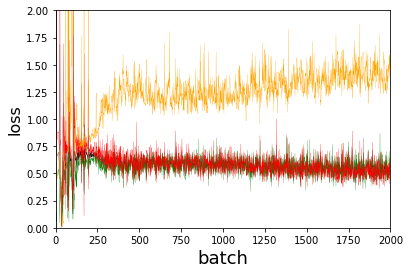

In [9]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color="black", linewidth=0.25)
plt.plot([x[1] for x in gan.d_losses], color="green", linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color="red", linewidth=0.25)
plt.plot([x[0] for x in gan.g_losses], color="orange", linewidth=0.25)

plt.xlabel("batch", fontsize=18)
plt.ylabel("loss", fontsize=16)
plt.xlim(0, 2000)
plt.ylim(0, 2)
plt.show()

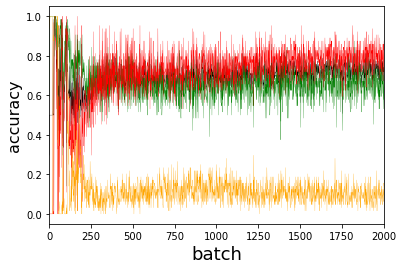

In [10]:
fig = plt.figure()
plt.plot([x[3] for x in gan.d_losses], color="black", linewidth=0.25)
plt.plot([x[4] for x in gan.d_losses], color="green", linewidth=0.25)
plt.plot([x[5] for x in gan.d_losses], color="red", linewidth=0.25)
plt.plot([x[1] for x in gan.g_losses], color="orange", linewidth=0.25)

plt.xlabel("batch", fontsize=18)
plt.ylabel("accuracy", fontsize=16)
plt.xlim(0, 2000)
plt.show()

## 生成图片及对比与生成图片相似的原始图片

In [11]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [12]:
r, c = 5, 5

idx = np.random.randint(0, x_train.shape[0], 32)
true_imgs = (x_train[idx] + 1) * 0.5

fig, axs = plt.subplots(r, c, figsize=(15, 15))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(true_imgs[cnt], cmap="Greys")
        axs[i, j].axis("off")
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/real.png"))
plt.close()

In [13]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, gan.z_dim))
gen_imgs = gan.generator.predict(noise)
gen_imgs = 0.5 * (gen_imgs + 1)

fig, axs = plt.subplots(r, c, figsize=(15, 15))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(np.squeeze(gen_imgs[cnt, :, :, :]), cmap="Greys")
        axs[i, j].axis("off")
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample.png"))
plt.close()

fig, axs = plt.subplots(r, c, figsize=(15, 15))
cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train + 1) * 0.5):
            diff = compare_images(gen_imgs[cnt, :, :, :], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="Greys")
        axs[i, j].axis("off")
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample_closest.png"))
plt.close()